# Binary Classification
Binary Classification is the task of predicting a binary label. For example, is an email spam or not spam? Should I show this ad to this user or not? Will it rain tomorrow or not? This notebook illustrates algorithms for making these types of predictions.

## Dataset Overview

The Adult dataset is publicly available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Adult). This data derives from census data and consists of information about 48842 individuals and their annual income. You can use this information to predict if an individual earns <=50K or >50k a year. The dataset consists of both numeric and categorical variables.

**Attribute Information:**

- age: continuous
- workclass: Private,Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
- fnlwgt: continuous
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc...
- education-num: continuous
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent...
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners...
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: Female, Male
- capital-gain: continuous
- capital-loss: continuous
- hours-per-week: continuous
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany...
- Target/Label: - <=50K, >50K

In [1]:
import mlflow.pyfunc
import mlflow.spark
import mlflow
from mlflow.tracking import MlflowClient
 
mlflow.set_tracking_uri("http://host.docker.internal:5000")
client = MlflowClient("http://host.docker.internal:5000")

In [2]:
from pyspark import SparkFiles
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('Adult binary classification').getOrCreate()

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)

In [12]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType
 
schema = StructType([
  StructField("age", DoubleType(), False),
  StructField("workclass", StringType(), False),
  StructField("fnlwgt", DoubleType(), False),
  StructField("education", StringType(), False),
  StructField("education_num", DoubleType(), False),
  StructField("marital_status", StringType(), False),
  StructField("occupation", StringType(), False),
  StructField("relationship", StringType(), False),
  StructField("race", StringType(), False),
  StructField("sex", StringType(), False),
  StructField("capital_gain", DoubleType(), False),
  StructField("capital_loss", DoubleType(), False),
  StructField("hours_per_week", DoubleType(), False),
  StructField("native_country", StringType(), False),
  StructField("income", StringType(), False)
])
 
dataset = spark.read.csv("file://"+SparkFiles.get("adult.data"), schema=schema)
cols = dataset.columns

## Preprocess Data
To use algorithms like Logistic Regression, you must first convert the categorical variables in the dataset into numeric variables. There are two ways to do this.

- Category Indexing
This is basically assigning a numeric value to each category from {0, 1, 2, ...numCategories-1}. This introduces an implicit ordering among your categories, and is more suitable for ordinal variables (eg: Poor: 0, Average: 1, Good: 2)

- One-Hot Encoding
This converts categories into binary vectors with at most one nonzero value (eg: (Blue: [1, 0]), (Green: [0, 1]), (Red: [0, 0]))

This notebook uses a combination of StringIndexer and, depending on your Spark version, either OneHotEncoder or OneHotEncoderEstimator to convert the categorical variables. OneHotEncoder and OneHotEncoderEstimator return a SparseVector.

Since there is more than one stage of feature transformations, use a Pipeline to tie the stages together. This simplifies the code.

In [13]:
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [14]:
categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    from pyspark.ml.feature import OneHotEncoder
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

The above code basically indexes each categorical column using the `StringIndexer`, and then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row.

Use the `StringIndexer` again to encode labels to label indices.

In [15]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

Use a `VectorAssembler` to combine all the feature columns into a single vector column. This includes both the numeric columns and the one-hot encoded binary vector columns in the dataset.

In [16]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Run the stages as a `Pipeline`. This puts the data through all of the feature transformations in a single call.

In [18]:
from pyspark.ml.classification import LogisticRegression
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(dataset)
preppedDataDF = pipelineModel.transform(dataset)

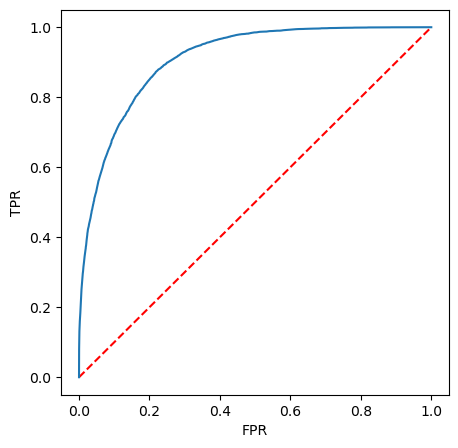

In [20]:
# Fit model to prepped data
lrModel = LogisticRegression().fit(preppedDataDF)
 
# ROC for training data
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [23]:
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)
dataset.show(1)

+-----+--------------------+----+----------+-------+----------+-------------+--------------+-------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|label|            features| age| workclass| fnlwgt| education|education_num|marital_status|   occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-----+--------------------+----+----------+-------+----------+-------------+--------------+-------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|  0.0|(100,[4,10,24,32,...|39.0| State-gov|77516.0| Bachelors|         13.0| Never-married| Adm-clerical| Not-in-family| White| Male|      2174.0|         0.0|          40.0| United-States| <=50K|
+-----+--------------------+----+----------+-------+----------+-------------+--------------+-------------+--------------+------+-----+------------+------------+--------------+--------------+------+
only showi

In [24]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22832
9729


## Fit and Evaluate Models

In [26]:
from pyspark.ml.classification import LogisticRegression
 
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
 
# Train model with Training Data
lrModel = lr.fit(trainingData)
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show(2)

+-----+----------+--------------------+----+---------------+
|label|prediction|         probability| age|     occupation|
+-----+----------+--------------------+----+---------------+
|  0.0|       1.0|[0.16646708724833...|36.0| Prof-specialty|
|  0.0|       0.0|[0.70012031106347...|32.0| Prof-specialty|
+-----+----------+--------------------+----+---------------+
only showing top 2 rows



Use `BinaryClassificationEvaluator` to evaluate the model.

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9010633018702178

In [28]:
evaluator.getMetricName()

'areaUnderROC'

The evaluator accepts two kinds of metrics - `areaUnderROC` and `areaUnderPR`. Set it to `areaUnderPR` by using `evaluator.setMetricName("areaUnderPR")`.

Now, tune the model using `ParamGridBuilder` and `CrossValidator`.

You can use `explainParams()` to print a list of all parameters and their definitions.

In [30]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
 
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [32]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
 
# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [33]:
# Use the test set to measure the accuracy of the model on new data
predictions = cvModel.transform(testData)

In [34]:

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.8997203469558716

In [35]:
print('Model Intercept: ', cvModel.bestModel.intercept)

Model Intercept:  -6.336365999298099


In [36]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = spark.createDataFrame(weights, ["Feature Weight"])
weightsDF.show()

+--------------------+
|      Feature Weight|
+--------------------+
| 0.10492555077522134|
| -0.3128222519796268|
|-0.06075451360468...|
| -0.2721306281794785|
|-0.14581243598919214|
|  0.3495304348424823|
| 0.47753854084743574|
| -2.4920423132828398|
|-0.18817807301492645|
| 0.02457242800190841|
|  0.4055326717725701|
|  0.6041914661074328|
| 0.09249180451745206|
| -0.6495393362369409|
|-0.06796598188360077|
|   -0.50113851942221|
| -0.7555258791036417|
|  0.8758631574746794|
| -0.6424968866720012|
| -0.3124342654495672|
+--------------------+
only showing top 20 rows



In [37]:
# View best model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show()

+-----+----------+--------------------+----+---------------+
|label|prediction|         probability| age|     occupation|
+-----+----------+--------------------+----+---------------+
|  0.0|       1.0|[0.21060910009532...|36.0| Prof-specialty|
|  0.0|       0.0|[0.68097448822474...|32.0| Prof-specialty|
|  0.0|       0.0|[0.54341491059548...|33.0| Prof-specialty|
|  0.0|       0.0|[0.65860417846993...|39.0| Prof-specialty|
|  0.0|       0.0|[0.61463593853443...|39.0| Prof-specialty|
|  0.0|       0.0|[0.60241279947003...|50.0| Prof-specialty|
|  0.0|       0.0|[0.59586897256623...|51.0| Prof-specialty|
|  0.0|       0.0|[0.59681289807548...|60.0| Prof-specialty|
|  0.0|       0.0|[0.72170646267586...|34.0| Prof-specialty|
|  0.0|       0.0|[0.96796930272851...|20.0| Prof-specialty|
|  0.0|       1.0|[0.47756430733627...|35.0| Prof-specialty|
|  0.0|       0.0|[0.52627860330667...|42.0| Prof-specialty|
|  0.0|       0.0|[0.56664870040475...|43.0| Prof-specialty|
|  0.0|       0.0|[0.696

## Decision Tree

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier
 
# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)
 
# Train model with Training Data
dtModel = dt.fit(trainingData)


In [39]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  11
depth =  3


In [40]:
display(dtModel)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a0f7d5677e06, depth=3, numNodes=11, numClasses=2, numFeatures=100

In [41]:
# Make predictions on test data using the Transformer.transform() method.
predictions = dtModel.transform(testData)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [44]:
# View model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show(2)

+-----+----------+--------------------+----+---------------+
|label|prediction|         probability| age|     occupation|
+-----+----------+--------------------+----+---------------+
|  0.0|       0.0|[0.68822950358599...|36.0| Prof-specialty|
|  0.0|       0.0|[0.68822950358599...|32.0| Prof-specialty|
+-----+----------+--------------------+----+---------------+
only showing top 2 rows



In [45]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.761369082285424

Entropy and the Gini coefficient are the supported measures of impurity for `Decision Trees`. This is `Gini` by default. Changing this value is simple, `model.setImpurity("Entropy")`.

In [47]:
dt.getImpurity()

'gini'

Now tune the model with using ParamGridBuilder and CrossValidator.

With three values for maxDepth and three values for maxBin, the grid has 4 x 3 = 12 parameter settings for CrossValidator.

In [48]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

In [49]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
 
# Run cross validations
cvModel = cv.fit(trainingData)
# Takes ~5 minutes

In [50]:
print("numNodes = ", cvModel.bestModel.numNodes)
print("depth = ", cvModel.bestModel.depth)

numNodes =  385
depth =  10


In [51]:
# Use test set to measure the accuracy of the model on new data
predictions = cvModel.transform(testData)

In [52]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.7876576458601124

In [53]:
# View Best model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show()

+-----+----------+--------------------+----+---------------+
|label|prediction|         probability| age|     occupation|
+-----+----------+--------------------+----+---------------+
|  0.0|       0.0|     [0.8125,0.1875]|36.0| Prof-specialty|
|  0.0|       0.0|[0.84040747028862...|32.0| Prof-specialty|
|  0.0|       0.0|[0.73248407643312...|33.0| Prof-specialty|
|  0.0|       0.0|[0.65073746312684...|39.0| Prof-specialty|
|  0.0|       0.0|[0.65073746312684...|39.0| Prof-specialty|
|  0.0|       0.0|[0.65073746312684...|50.0| Prof-specialty|
|  0.0|       0.0|[0.65073746312684...|51.0| Prof-specialty|
|  0.0|       0.0|[0.89389067524115...|60.0| Prof-specialty|
|  0.0|       0.0|[0.84040747028862...|34.0| Prof-specialty|
|  0.0|       0.0|[0.91361256544502...|20.0| Prof-specialty|
|  0.0|       0.0|[0.84040747028862...|35.0| Prof-specialty|
|  0.0|       0.0|[0.65073746312684...|42.0| Prof-specialty|
|  0.0|       0.0|[0.65073746312684...|43.0| Prof-specialty|
|  0.0|       0.0|[0.739

## Random Forest

In [54]:
from pyspark.ml.classification import RandomForestClassifier
 
# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
 
# Train model with Training Data
rfModel = rf.fit(trainingData)

In [55]:
# Make predictions on test data using the Transformer.transform() method.
predictions = rfModel.transform(testData)

In [57]:
# View model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show(5)

+-----+----------+--------------------+----+---------------+
|label|prediction|         probability| age|     occupation|
+-----+----------+--------------------+----+---------------+
|  0.0|       0.0|[0.50179581871895...|36.0| Prof-specialty|
|  0.0|       0.0|[0.68486094126803...|32.0| Prof-specialty|
|  0.0|       0.0|[0.66929320945799...|33.0| Prof-specialty|
|  0.0|       0.0|[0.63430850456527...|39.0| Prof-specialty|
|  0.0|       0.0|[0.61035413107809...|39.0| Prof-specialty|
+-----+----------+--------------------+----+---------------+
only showing top 5 rows



In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.8828832119722976

Now tune the model with ParamGridBuilder and CrossValidator.

With three values for maxDepth, two values for maxBin, and two values for numTrees, the grid has 3 x 2 x 2 = 12 parameter settings for CrossValidator.

In [59]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
 
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

In [60]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
 
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(trainingData)

In [61]:
# Use the test set to measure the accuracy of the model on new data
predictions = cvModel.transform(testData)
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.8883498862204388

In [63]:
# View model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
selected.show(5)

+-----+----------+--------------------+----+---------------+
|label|prediction|         probability| age|     occupation|
+-----+----------+--------------------+----+---------------+
|  0.0|       0.0|[0.54762221128431...|36.0| Prof-specialty|
|  0.0|       0.0|[0.67236950383125...|32.0| Prof-specialty|
|  0.0|       0.0|[0.66240142283041...|33.0| Prof-specialty|
|  0.0|       0.0|[0.61394440029768...|39.0| Prof-specialty|
|  0.0|       0.0|[0.60397631929684...|39.0| Prof-specialty|
+-----+----------+--------------------+----+---------------+
only showing top 5 rows



In [62]:
bestModel = cvModel.bestModel

In [64]:
# Generate predictions for entire dataset
finalPredictions = bestModel.transform(dataset)

In [65]:
# Evaluate best model
evaluator.evaluate(finalPredictions)

0.8952770867925589

In [66]:
finalPredictions.createOrReplaceTempView("finalPredictions")

In [69]:
spark.sql("""SELECT occupation, prediction, count(*) AS count
FROM finalPredictions
GROUP BY occupation, prediction
ORDER BY occupation""").show()

+------------------+----------+-----+
|        occupation|prediction|count|
+------------------+----------+-----+
|                 ?|       1.0|  139|
|                 ?|       0.0| 1704|
|      Adm-clerical|       1.0|  202|
|      Adm-clerical|       0.0| 3568|
|      Armed-Forces|       1.0|    1|
|      Armed-Forces|       0.0|    8|
|      Craft-repair|       1.0|  249|
|      Craft-repair|       0.0| 3850|
|   Exec-managerial|       0.0| 2698|
|   Exec-managerial|       1.0| 1368|
|   Farming-fishing|       1.0|   58|
|   Farming-fishing|       0.0|  936|
| Handlers-cleaners|       0.0| 1339|
| Handlers-cleaners|       1.0|   31|
| Machine-op-inspct|       0.0| 1929|
| Machine-op-inspct|       1.0|   73|
|     Other-service|       0.0| 3258|
|     Other-service|       1.0|   37|
|   Priv-house-serv|       0.0|  149|
|    Prof-specialty|       0.0| 2416|
+------------------+----------+-----+
only showing top 20 rows

